# Diffusion MRI: Basic Physics

By: Diego Hernando

Date: 12/7/2021

In [13]:
from numpy import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.animation as animation
from IPython.display import clear_output
#%matplotlib inline 
font = {'weight' : 'normal',
        'size'   : 20}


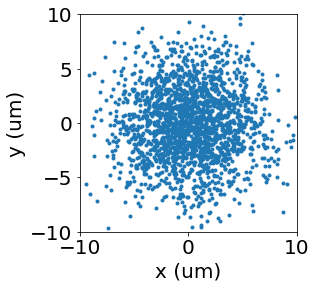

In [14]:
N = 2000 # Number of protons (water molecules)
T = 50 # Diffusion time in ms
dt = 0.1 # Time step in ms
NT = int(T/dt)
D = 2E-3 # Diffusion coefficient in mm2/s

# Define a cell with impermeable walls
cell_radius = 1000
angles = np.linspace(0,2*np.pi,200)

# Initial location of spins
pos0x = 4*rnd.rand(N)-2
pos0y = 4*rnd.rand(N)-2


# draw the figure so the animations will work
fig, ax = plt.subplots()
plt.rc('font', **font)
plt.show()
axes = plt.gca()
axes.set_aspect('equal')
axes.set_xlim(-10,10)
axes.set_ylim(-10,10)
points = ax.plot(pos0x,pos0y,'.')[0]
ax.plot(cell_radius*np.cos(angles), cell_radius*np.sin(angles),'k')

posx = np.zeros([N,NT])
posy = np.zeros([N,NT])
posx[:,0] = pos0x
posy[:,0] = pos0y
for kt in range(1,NT):
    posx[:,kt] = posx[:,kt-1] + np.sqrt(2*dt*D*1E3)*rnd.randn(N)
    posy[:,kt] = posy[:,kt-1] + np.sqrt(2*dt*D*1E3)*rnd.randn(N)  
    
    # Make sure that spins do not leave the cell
    undo = (posx[:,kt]**2 + posy[:,kt]**2) > cell_radius**2   
    posx[undo,kt] = posx[undo,kt-1]
    posy[undo,kt] = posy[undo,kt-1]
    
#    if (kt % 10) == 0:
    if kt<NT/20:
        clear_output(wait=True)
        points = plt.plot(posx[:,kt],posy[:,kt],'.')[0]   
        plt.plot(cell_radius*np.cos(angles), cell_radius*np.sin(angles),'k')
        plt.xlabel('x (um)')
        plt.ylabel('y (um)')
        axes = plt.gca()
        axes.set_aspect('equal')
        axes.set_xlim(-10,10)
        axes.set_ylim(-10,10)
        plt.show()
        plt.pause(0.001)

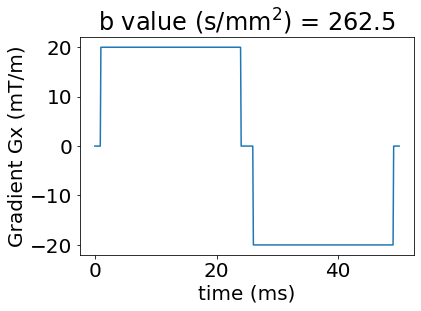

In [9]:
t = dt*np.linspace(0,NT,NT)
G = 0*t;
G[(t>1)*(t<24)] = 20 # In mT/m
G[(t>26)*(t<49)] = -20 # In mT/m
plt.plot(t,G)    

gammabar = 42.576E6
gamma = gammabar*2*np.pi
b = (gamma**2) * np.sum((np.cumsum(G*1E-3*dt*1E-3))**2)*dt*1E-3*1E-6
plt.title('b value (s/mm$^2$) = ' '{:.1f}'.format(b));
#plt.title('b value = ' str(np.round(b)));
plt.xlabel('time (ms)')
plt.ylabel('Gradient Gx (mT/m)')
plt.rc('font', **font)


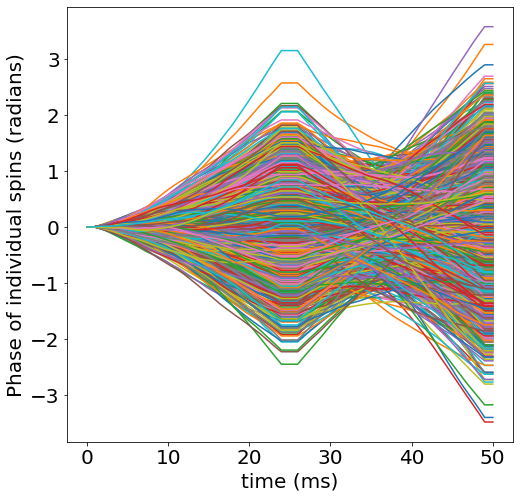

In [10]:

phase = np.zeros([N,NT])
for kt in range(1,NT):
    phase[:,kt] = phase[:,kt-1] + 2*np.pi*gammabar*G[kt]*posx[:,kt]*dt*1E-12
    
plt.figure(figsize=(8,8))    
plt.plot(t,np.transpose(phase[:,:]) );
plt.xlabel('time (ms)')
plt.ylabel('Phase of individual spins (radians)')
plt.rc('font', **font)


(0.6045142786160423+0.007783533731126268j)

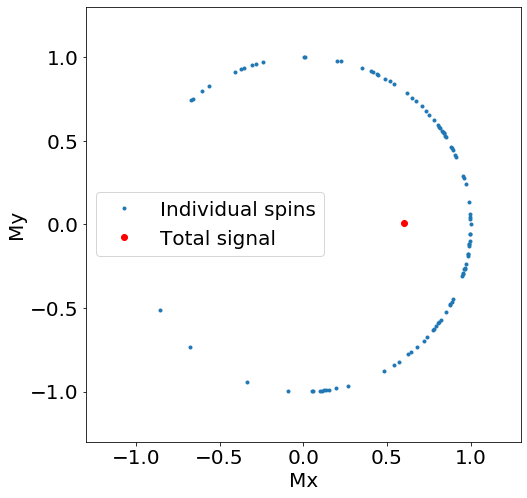

In [11]:
signal_per_spin = np.exp(1j*phase[:,NT-1])

signal_total = np.mean(signal_per_spin)

plt.figure(figsize=(8,8))
plt.plot(np.real(signal_per_spin[1:100]), np.imag(signal_per_spin[1:100]),'.', label='Individual spins')
plt.plot(np.real(signal_total), np.imag(signal_total),'.r', MarkerSize=12, label='Total signal')
plt.legend()
axes = plt.gca()
axes.set_aspect('equal')
axes.set_xlim(-1.3,1.3)
axes.set_ylim(-1.3,1.3)
plt.xlabel('Mx');
plt.ylabel('My');
plt.rc('font', **font)

signal_total

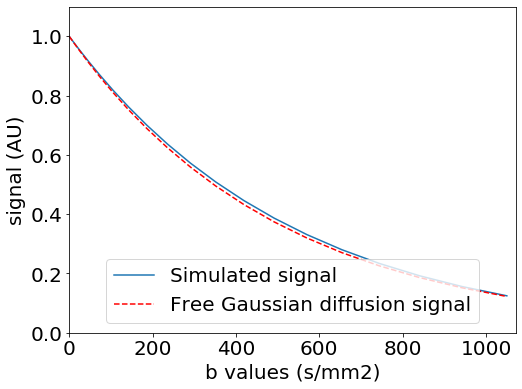

In [12]:
# Now let's get signals across many b values by scaling our gradient
num_b = 20 
G_max = 40
G_vals = np.linspace(0,G_max,num_b)

Gnorm = 0*t;
Gnorm[(t>1)*(t<24)] = 1 # In mT/m
Gnorm[(t>26)*(t<49)] = -1 # In mT/m

b = np.zeros(num_b)

signal = np.zeros(num_b) + 1j*np.zeros(num_b)


for kb in range(num_b):
    G_val = G_vals[kb]
    G = Gnorm*G_val
    b[kb] = (gamma**2) * np.sum((np.cumsum(G*1E-3*dt*1E-3))**2)*dt*1E-3*1E-6
    phase = np.zeros([N,NT])
    for kt in range(1,NT):
        phase[:,kt] = phase[:,kt-1] + 2*np.pi*gammabar*G[kt]*posx[:,kt]*dt*1E-12
    signal[kb] = np.mean(np.exp(1j*phase[:,NT-1]))
    
plt.figure(figsize=(8,6))
plt.plot(b,np.abs(signal),label='Simulated signal')
plt.xlabel('b values (s/mm2)')
plt.ylabel('signal (AU)')
axes = plt.gca()
axes.set_xlim(0,1.02*b[-1])
axes.set_ylim(0,1.1)
    
# Plot standard monoexponential decay, for comparison    
plt.plot(b,np.exp(-b*D),'r--',label='Free Gaussian diffusion signal')    
plt.legend(loc=8);
plt.rc('font', **font)

# Plot eye-ball apparent diffusion coefficient (ADC) fitting   
#ADC = 0.3E-3
#plt.plot(b,np.exp(-b*ADC),'m',label='Fitted ADC signal')    
#plt.legend(loc=8);
#plt.rc('font', **font)